In [141]:
from datetime import datetime, timezone, timedelta
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
import numpy as np
import mplfinance as mpf
import pandas as pd

In [53]:
# No keys required for crypto data
client = CryptoHistoricalDataClient()

In [64]:
# Daylight Savings Time
tz = timezone(timedelta(hours=-5))
# Creating request object
request_params = CryptoBarsRequest(
  symbol_or_symbols=["BTC/USD"],
  timeframe=TimeFrame.Minute,
  start=datetime.fromisoformat('2025-03-02T09:00:00-05:00'),
  end=datetime.fromisoformat('2025-03-02T13:00:00-05:00')
)

In [67]:
# Retrieve daily bars for Bitcoin in a DataFrame and printing it
btc_bars = client.get_crypto_bars(request_params)
# Convert to dataframe
df = btc_bars.df
# Update indexes to use only timestamp, as we are doing single symbol analysis
df = df.droplevel('symbol')
df.index = df.index.tz_convert('US/Eastern')
df

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2025-03-02 09:00:00-05:00,85724.900,85729.184,85679.4000,85729.1840,0.000069,1.0,85724.900000
2025-03-02 09:01:00-05:00,85792.368,85792.368,85710.4180,85769.8950,0.000589,1.0,85792.368000
2025-03-02 09:03:00-05:00,85811.370,85811.370,85727.2795,85772.7410,0.000074,1.0,85811.370000
2025-03-02 09:04:00-05:00,85813.814,85856.016,85813.8140,85856.0160,0.000000,0.0,85834.915000
2025-03-02 09:05:00-05:00,85828.264,85828.264,85769.9950,85797.2700,0.000085,1.0,85769.995000
...,...,...,...,...,...,...,...
2025-03-02 12:56:00-05:00,93716.395,93851.464,93669.2300,93694.7920,0.002544,2.0,93823.418794
2025-03-02 12:57:00-05:00,93734.893,94141.955,93734.8930,94050.6000,0.000000,0.0,93938.424000
2025-03-02 12:58:00-05:00,94091.850,94140.155,93976.3065,93976.3065,0.001000,1.0,94030.700000


In [200]:
important_dts = [datetime.fromisoformat(x) for x in ['2025-03-02T10:24:00-05:00', '2025-03-02T12:11:00-05:00']]
labels = ["First post", "Second post"]
marker_signal = []
# Iterate over low markers
for date,values in df.low.items():
    if date in important_dts:
        # Position marker slightly below value
        marker_signal.append(values * 0.99)
    else:
        marker_signal.append(np.nan)
# Subplot for markers
markers = mpf.make_addplot(marker_signal, type='scatter', markersize=50, marker="^", color='red', panel=0)

ValueError: Unrecognized marker style '11'

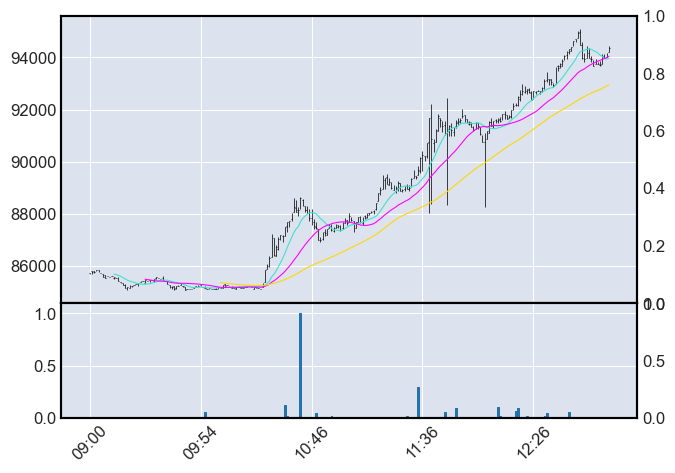

In [201]:
# Plot everything

plt = mpf.plot(df,mav=(12,26,60),volume=True, addplot=markers)